In [1]:
import pandas as pd
from utils.data_processing import EyeTrackingProcessor, GazeMetricsProcessor, MouseMetricsProcessor
import matplotlib.pyplot as plt

from collections import defaultdict
import numpy as np
import os
from tqdm import tqdm
from typing import Union, Dict, Tuple, Optional, Iterable
from pathlib import Path

from utils.task_data_io import PARQUET_NAME, list_parquet_files

In [2]:
def load_and_process(
    root_dir: Union[str, Path],
    columns: list[str],
    interpolate_cols: list[str],
    fill_cols: list[str],
    participants: Optional[Iterable[str]] = None,
    scenarios: Optional[Iterable[Union[str, int]]] = None,
    time_resampling: bool = True,
    fixed_window_ms: int | None = 3000,
    window_step_ms: int | None = None,
    min_task_presence: float = 0.5,
):
    # Get all data files
    file_index = list_parquet_files(root_dir, participants=participants, scenarios=scenarios)
    if not file_index:
        raise FileNotFoundError(f"No {PARQUET_NAME} found under {root_dir}")

    # Option: Only download the necessary columns
    needed = set(columns) | {
        "Event", "Participant name", "epoch_ms", "Recording timestamp [ms]"
    }
    
    # Load data
    processor = EyeTrackingProcessor()
    all_data, atco_task_map = processor.load_data(file_index, want_columns=list(needed))

    ###### Chunking Strategy ######
    if fixed_window_ms is not None:
        chunks = processor.get_fixed_window_chunks(
            all_data,
            features=columns,
            window_ms=fixed_window_ms,
            step_ms=window_step_ms,
            min_presence=min_task_presence,
        )
    else:
        chunks = processor.get_features(all_data, columns)

    # Blink detection
    chunks, blinks = processor.detect_blinks(chunks)

    # Time-step resampling
    if time_resampling:
        resampled_chunks_time = processor.resample_task_chunks(
            chunks, interpolate_cols, mode="time", param=10
        )
        # post-process: Blink back to bool + fill others
        for task_id, chunk in resampled_chunks_time.items():
            chunk["Blink"] = chunk["Blink"] > 0.5
            for col in fill_cols:
                chunk[col] = chunk[col].ffill().bfill()
        return resampled_chunks_time, blinks, atco_task_map

    return chunks, blinks, atco_task_map

In [16]:
data_path = "/store/kruu/eye_tracking/training_data"
participant = ["010"]
scenarios = [3]
features = ['Recording timestamp [ms]', 'Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y', 'Event']
interpolate_cols = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y', "Blink"]
fill_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y']

# chunks_fixed_len, blinks_fixed_len, task_map_fixed_len = load_and_process(
#     root_dir=data_path,
#     columns=features,              # include the timestamp col here
#     interpolate_cols=interpolate_cols,
#     fill_cols=fill_columns,
#     participants=participant,
#     scenarios=scenarios,
#     time_resampling=False,
#     fixed_window_ms=12000,          # 3s windows
#     window_step_ms=2000,           # no overlap = None
#     min_task_presence=0.5 
# )

chunks_task, blinks_task, task_map_task = load_and_process(
    root_dir=data_path,
    columns=features,              # include the timestamp col here
    interpolate_cols=interpolate_cols,
    fill_cols=fill_columns,
    participants=participant,
    scenarios=scenarios,
    time_resampling=False,
    fixed_window_ms=None,          # 3s windows
    window_step_ms=None,           # no overlap = None
)

⚠️ Unmatched 'end' for Task 9 at 445919.0
⚠️ Unmatched 'end' for Task 0 at 574344.0
⚠️ Unmatched 'end' for Task 5 at 938399.0
⚠️ Unmatched 'end' for Task 9 at 1164773.0
⚠️ Unmatched 'end' for Task 7 at 2786225.0
⚠️ Unmatched 'start' for Task 9 at 1288240.0
⚠️ Unmatched 'start' for Task 9 at 1678861.0
⚠️ Unmatched 'start' for Task 8 at 364609.0
⚠️ Unmatched 'start' for Task 10 at 598963.0
⚠️ Unmatched 'start' for Task 10 at 2926149.0
⚠️ Unmatched 'start' for Task 2 at 2222645.0
⚠️ Unmatched 'start' for Task 1 at 1336720.0
⚠️ Unmatched 'start' for Task 1 at 1384217.0
⚠️ Unmatched 'start' for Task 1 at 1463612.0
⚠️ Unmatched 'start' for Task 5 at 1631738.0
⚠️ Unmatched 'start' for Task 5 at 1719120.0


In [5]:
chunks_task['010_3_9_0']

,Recording timestamp [ms],Gaze point X [DACS px],Gaze point Y [DACS px],Mouse position X,Mouse position Y,Event,Task_id,Task_execution,Participant name,Scenario_id,id,Blink,Loss of Attention
0,253929.0,NaN,NaN,NaN,NaN,Task 9,9,0,010,3,010_3_9_0,1,True
1,253930.0,1180.0,358.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True
2,253938.0,1155.0,424.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True
3,253946.0,1116.0,479.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True
4,253955.0,1092.0,562.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...
943,261779.0,1142.0,819.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True
944,261788.0,1142.0,820.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True
945,261796.0,1142.0,819.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True
946,261804.0,1143.0,819.0,NaN,NaN,None,9,0,010,3,010_3_9_0,1,True


In [10]:
print(task_map_fixed_len)
print(task_map_task)

{'Aircraft requests': 'Task 0', 'Conflict resolution': 'Task 1', 'Coordination response': 'Task 2', 'Entry conditions': 'Task 3', 'Entry coordination': 'Task 4', 'Exit conditions': 'Task 5', 'Exit coordination': 'Task 6', 'Return to route': 'Task 7', 'Zone conflict': 'Task 8', 'assume': 'Task 9', 'transfer': 'Task 10'}
{'Aircraft requests': 'Task 0', 'Conflict resolution': 'Task 1', 'Coordination response': 'Task 2', 'Entry conditions': 'Task 3', 'Entry coordination': 'Task 4', 'Exit conditions': 'Task 5', 'Exit coordination': 'Task 6', 'Return to route': 'Task 7', 'Zone conflict': 'Task 8', 'assume': 'Task 9', 'transfer': 'Task 10'}


In [11]:
from collections import Counter

# Task 2 is always too brief to be associated with a task

print("Number of task occurences for fixed length window: ")
task_window_counts = Counter(int(df["Task_id"].iloc[0]) for df in chunks_fixed_len.values())
# Pretty print
for task_id in sorted(task_window_counts):
    print(f"Task {task_id}: {task_window_counts[task_id]} windows")
    
print("\n")

print("Number of task occurences in the dataset: ")
task_window_counts = Counter(int(df["Task_id"].iloc[0]) for df in chunks_task.values())
# Pretty print
for task_id in sorted(task_window_counts):
    print(f"Task {task_id}: {task_window_counts[task_id]} windows")

Number of task occurences for fixed length window: 
Task 0: 7 windows
Task 1: 51 windows
Task 2: 33 windows
Task 3: 14 windows
Task 4: 23 windows
Task 8: 149 windows
Task 9: 453 windows
Task 10: 671 windows


Number of task occurences in the dataset: 
Task 0: 3 windows
Task 1: 7 windows
Task 2: 5 windows
Task 3: 3 windows
Task 4: 5 windows
Task 6: 2 windows
Task 7: 12 windows
Task 8: 12 windows
Task 9: 26 windows
Task 10: 32 windows


In [12]:
durations_by_task = defaultdict(list)

for df in chunks_task.values():
    task_id = int(df["Task_id"].iloc[0])

    ts_col = "Recording timestamp [ms]"
    ts = df[ts_col].astype(float)
    dur_ms = float(ts.max() - ts.min())

    durations_by_task[task_id].append(dur_ms)

avg_ms_by_task = {task: float(np.mean(durs)) for task, durs in durations_by_task.items()}

for task_id in sorted(avg_ms_by_task):
    print(f"Task {task_id}: {avg_ms_by_task[task_id]:.1f} ms ({avg_ms_by_task[task_id]/1000:.3f} s)")

Task 0: 17051.0 ms (17.051 s)
Task 1: 170982.1 ms (170.982 s)
Task 2: 19645.0 ms (19.645 s)
Task 3: 18518.3 ms (18.518 s)
Task 4: 14243.0 ms (14.243 s)
Task 6: 8207.0 ms (8.207 s)
Task 7: 9030.5 ms (9.030 s)
Task 8: 31206.7 ms (31.207 s)
Task 9: 39777.7 ms (39.778 s)
Task 10: 50628.7 ms (50.629 s)


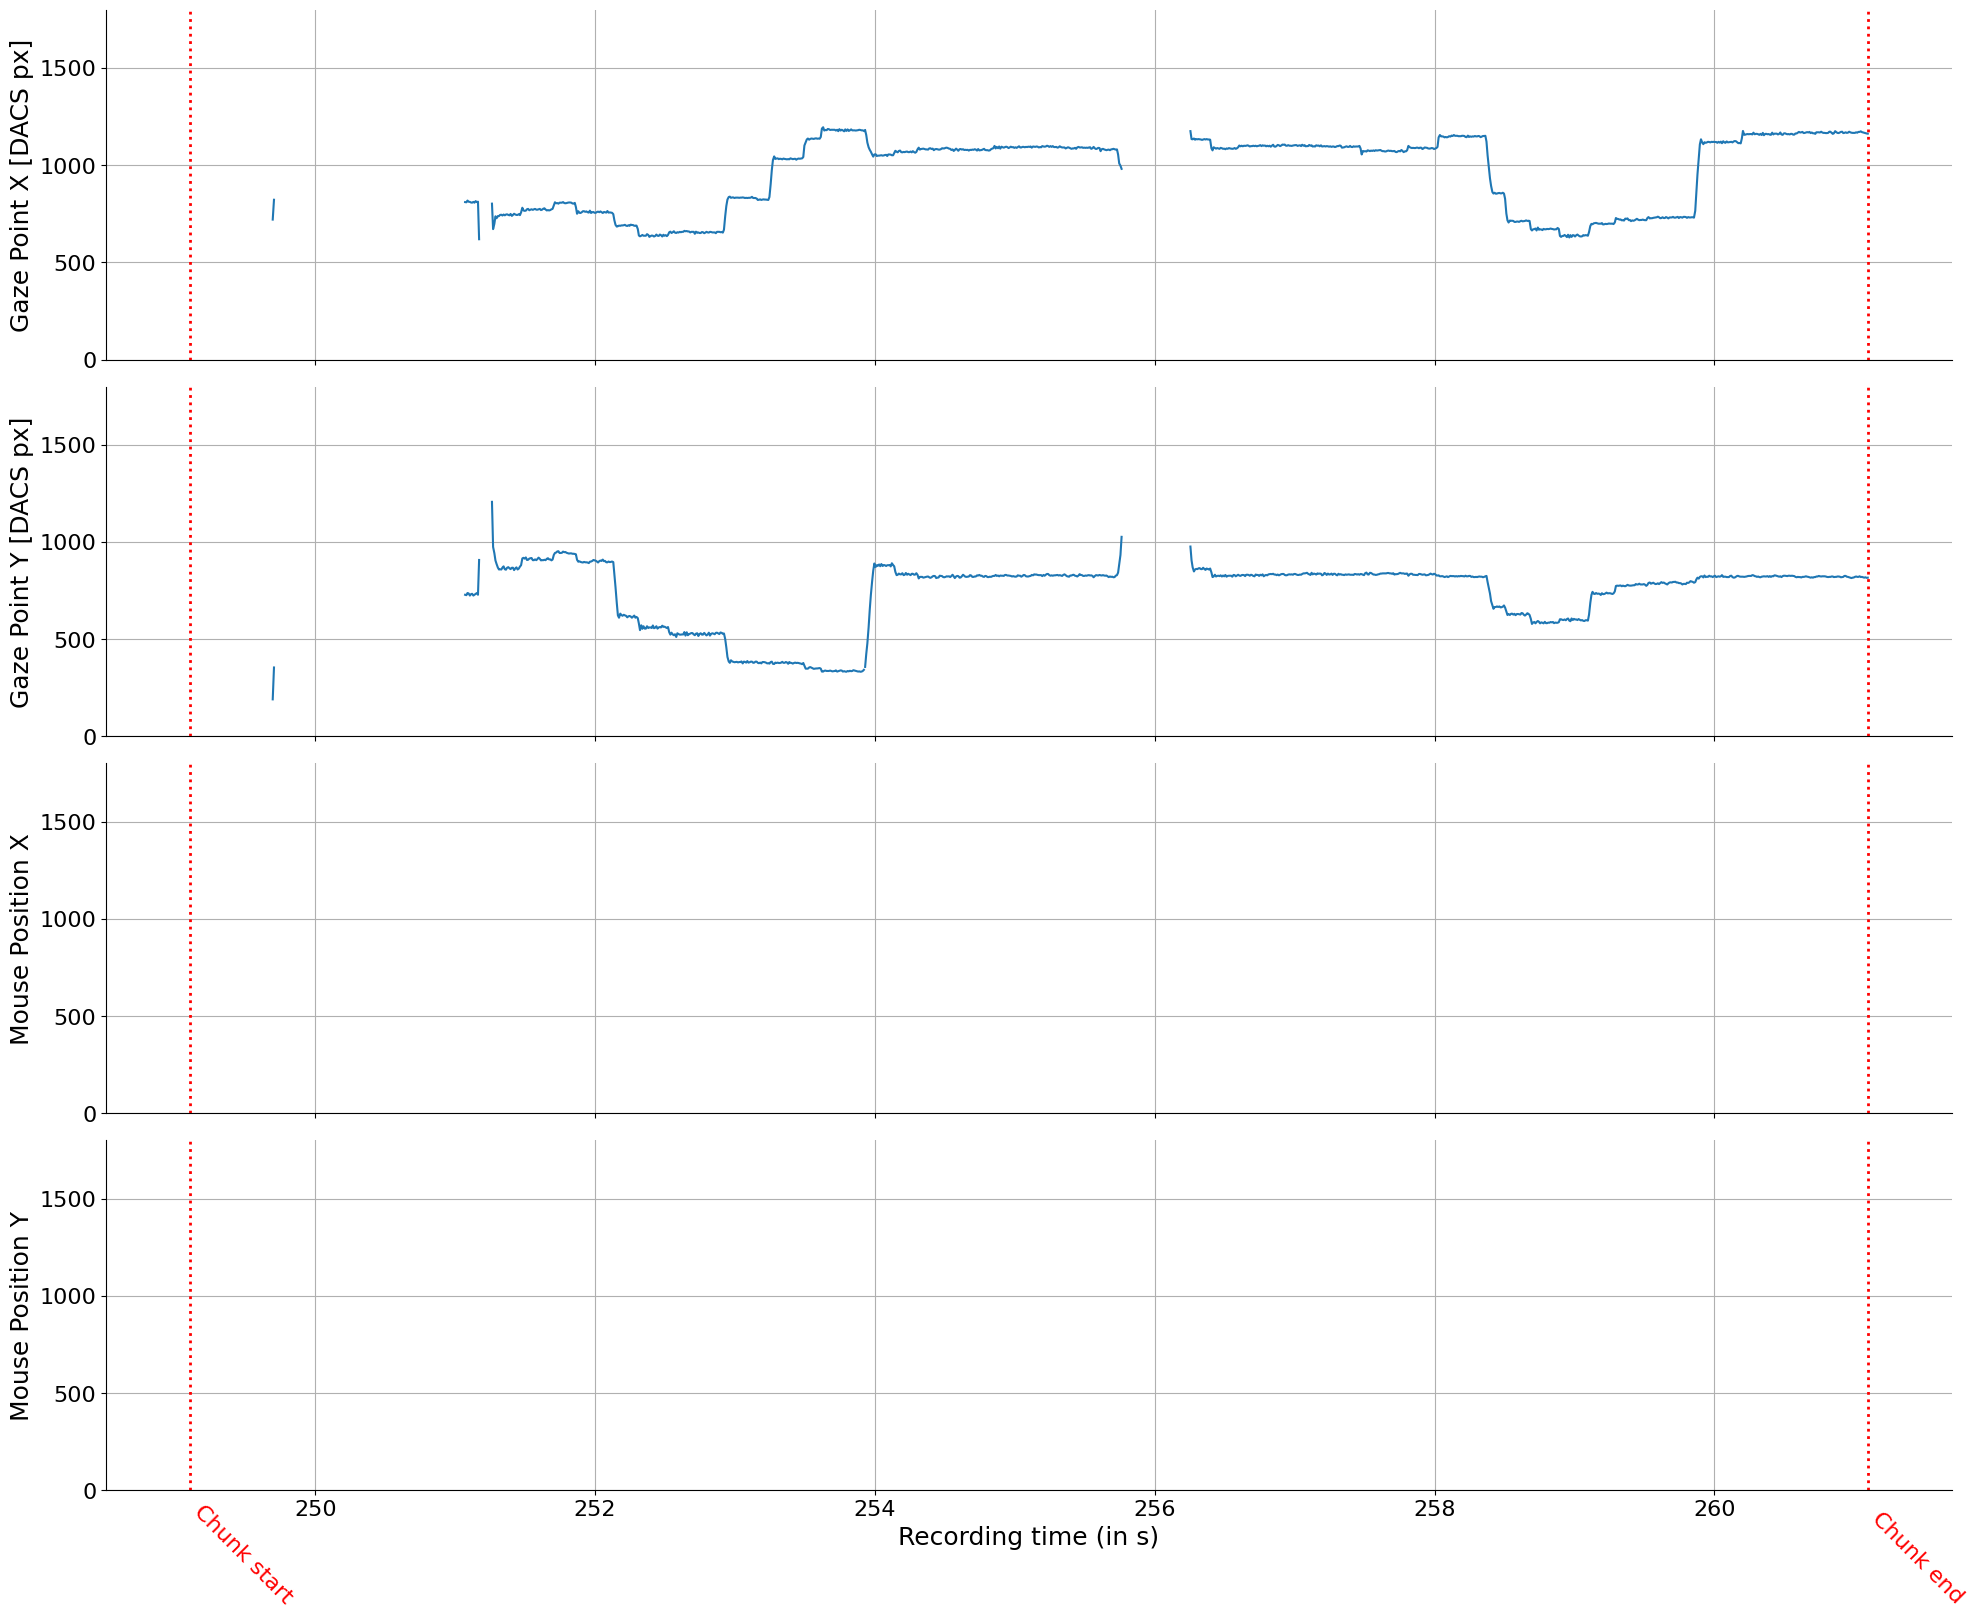

In [15]:
id_task = "010_3_9_0"
task_plot = chunks_fixed_len[id_task]

fig, axs = plt.subplots(4, 1, figsize=(20, 16), sharex=True)
# Convert timestamps to seconds
timestamps_sec = task_plot["Recording timestamp [ms]"] / 1e3
start_time_sec = task_plot.iloc[0]["Recording timestamp [ms]"] / 1e3
end_time_sec = task_plot.iloc[-1]["Recording timestamp [ms]"] / 1e3

# Titles for each subplot
titles = ['Gaze Point X [DACS px]', 'Gaze Point Y [DACS px]', 'Mouse Position X', 'Mouse Position Y']
data_columns = ['Gaze point X [DACS px]', 'Gaze point Y [DACS px]', 'Mouse position X', 'Mouse position Y']

# Plot each subplot
for ax, title, col in zip(axs, titles, data_columns):
    ax.plot(timestamps_sec, task_plot[col], label=title)
    ax.axvline(x=start_time_sec, color='red', linestyle=':', linewidth=2)
    ax.axvline(x=end_time_sec, color='red', linestyle=':', linewidth=2)
    ax.set_ylim(0, 1800)
    ax.set_ylabel(title)
    ax.grid(True)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# Add labels directly to vertical lines on the top subplot only
axs[-1].text(start_time_sec, -600, 'Chunk start', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)
axs[-1].text(end_time_sec, -600, 'Chunk end', color='red', rotation=-45, verticalalignment='bottom', fontsize = 16)

# X-axis label on the last subplot
axs[-1].set_xlabel('Recording time (in s)', fontsize = 18)

for ax in axs:
    ax.tick_params(axis='both', labelsize=16)
    ax.set_ylabel(ax.get_ylabel(), fontsize=18)

plt.tight_layout()
plt.show()